In [1]:
import time
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [2]:
#SETTINGS
set_random_seed = 1
set_number_epochs = 20
set_generator_learning_rate = 0.0002
set_discriminator_learning_rate = 0.0002
set_batch_size = 128 ##if run out of memory, choose a smaller number for set_batch_size
set_beta1 = 0.5 
set_beta2 = 0.999 
set_number_cpus = 1
set_latent_dim = 5 
set_number_classes = 10

In [3]:
#MNIST DATASET
##transform image
custom_transform = transforms.Compose([
    transforms.Resize(32),###make image size 32x32
    transforms.ToTensor() ###scale input image to 0-1 range
])

##create dataloader  
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=custom_transform,
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=set_batch_size,
                          num_workers=set_number_cpus,
                          shuffle=True)

In [4]:
# UTILIZABLE LABEL FUNCTIONS
def random_onehot_labels(batch_size):
    labels= []
    batch = torch.zeros(batch_size, 10)
    for b in batch:
        label = random.randint(0, 9)
        b[label] = 1
        labels.append(label)
    return labels, batch
##--------------------------------------------------------------------------------------------------------------   
def random_same_onehot_labels(label, batch_size):
    labels= []
    batch = torch.zeros(batch_size, 10)
    for b in batch:
        b[label] = 1
        labels.append(label)
    return labels, batch
##--------------------------------------------------------------------------------------------------------------   
def cnn_labels(labels):
    onehots = []
    for label in labels:
        onehot = torch.zeros(10, 32, 32)
        onehot[label] = 1
        onehots.append(onehot)
    return torch.stack(onehots).to(device)


# UTILIZABLE MODELS
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) ##input.size(0): batch size
##--------------------------------------------------------------------------------------------------------------   
class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 4, 4)
##--------------------------------------------------------------------------------------------------------------   
class Concat(nn.Module):
    def forward(self, x):
        x1 = x[0]
        x2 = x[1]
        return torch.cat((x1, x2), 1)

<img src="static/depict/low_cgan.png"/>

In [5]:
#CGAN MODEL
class CGAN(torch.nn.Module): ##CGAN: Conditional Generative Adversarial Network
    def __init__(self):
        super(CGAN, self).__init__()
        ##discrimation part
        self.discriminator_img = nn.Sequential(
            ###batch_sizex1x32x32 => batch_sizex64x16x16
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.discriminator_y = nn.Sequential(
            ###batch_sizex10x32x32 => batch_sizex64x16x16
            nn.Conv2d(in_channels=set_number_classes, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
            
        )
        self.discriminator = nn.Sequential(
            ###batch_sizex128x16x16
            Concat(),
            ###batch_sizex128x16x16 => batch_sizex256x8x8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x8x8 => batch_sizex512x4x4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            ###batch_sizex512*4*4
            nn.Flatten(),
            ###batch_sizex1
            nn.Linear(512*4*4, 1, bias=False)
        )

        ##generator part
        self.generator_z = nn.Sequential(
            ###batch_sizex256*4*4
            nn.Linear(set_latent_dim, 256*4*4, bias=False),
            nn.BatchNorm1d(256*4*4),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x4x4
            Reshape1()
        )
        self.generator_y = nn.Sequential(
            ###batch_sizex256*4*4
            nn.Linear(set_number_classes, 256*4*4, bias=False),
            nn.BatchNorm1d(256*4*4),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x4x4
            Reshape1()
        )
        self.generator = nn.Sequential(
            ### batch_sizex512x4x4
            Concat(), 
            ###batch_sizex512x4x4 => batch_sizex256x8x8
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x8x8 => batch_sizex128x16x16
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2), 
            ###batch_sizex128x16x16 => batch_sizex1x32x32
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )     
    
    def generator_forward(self, z, y):
        out1 = self.generator_z(z)
        out2 = self.generator_y(y)
        return self.generator([out1, out2])
    
    def discriminator_forward(self, img, y):
        out1 = self.discriminator_img(img)
        out2 = self.discriminator_y(y)
        out = self.discriminator([out1, out2])
        return out

In [6]:
#SETUP CGAN MODELS
## initialize models
torch.manual_seed(set_random_seed)
model = CGAN()

##device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

##optimizers
optim_generator = torch.optim.Adam(model.generator.parameters(), lr=set_generator_learning_rate, betas=(set_beta1, set_beta2))
optim_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=set_discriminator_learning_rate, betas=(set_beta1, set_beta2))

##current device
device

device(type='cuda', index=0)

In [7]:
#TRAINING    
time_start = time.time()
discr_costs = []
gener_costs = []
for epoch in range(set_number_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        ##each feature has a size 128x1x32x32
        features = (features - 0.5)*2  ## Normalize each feature to [-1, 1] range
        features = features.to(device)
        targets = targets.to(device)
        
        ##ground truth tensors
        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)

        ## train generator to fool discrimator
        ### make new tensor images
        z = torch.zeros((targets.size(0), set_latent_dim)).uniform_(-1.0, 1.0).to(device)
        actual_labels, y = random_onehot_labels(targets.size(0))
        y = y.to(device)
        generated_features = model.generator_forward(z, y)
        ### calculate generlation loss
        discr_pred = model.discriminator_forward(generated_features, cnn_labels(actual_labels))
        discr_pred = discr_pred.view(-1)
        gener_loss = F.binary_cross_entropy_with_logits(discr_pred, valid*0.9)
        ###update gradients
        optim_generator.zero_grad()
        gener_loss.backward()
        optim_generator.step()

        ## train discriminator to distinguish the real numbers from the fake numbers created by generator
        discr_pred_real = model.discriminator_forward(features, cnn_labels(targets))
        discr_pred_real = discr_pred_real.view(-1)
        real_loss = F.binary_cross_entropy_with_logits(discr_pred_real, valid*0.9)
        ### calculate  discimination loss
        discr_pred_fake = model.discriminator_forward(generated_features.detach(), cnn_labels(actual_labels))
        discr_pred_fake= discr_pred_fake.view(-1)
        fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake, fake)
        discr_loss = real_loss + fake_loss
        ###update gradients
        optim_discriminator.zero_grad()
        discr_loss.backward()
        optim_discriminator.step()        
        
        ##save losses
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())

        ##log text
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.3f/%.3f' 
                   %(epoch+1, set_number_epochs, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))
    ## time elapsed  
    minutes = (time.time() - time_start) / 60
    unit = 'minutes' if minutes > 1  else 'minute'
    print(f'Time elapsed: {minutes:.2f} {unit}')
    print('==========================================================')

## save model
torch.save(model.state_dict(), 'static/inference/MATH4KID.pt')

Epoch: 001/020 | Batch 000/469 | Gen/Dis Loss: 0.553/1.618
Epoch: 001/020 | Batch 100/469 | Gen/Dis Loss: 6.204/0.333
Epoch: 001/020 | Batch 200/469 | Gen/Dis Loss: 6.692/0.328
Epoch: 001/020 | Batch 300/469 | Gen/Dis Loss: 1.722/0.635
Epoch: 001/020 | Batch 400/469 | Gen/Dis Loss: 5.981/0.329
Time elapsed: 0.47 minute
Epoch: 002/020 | Batch 000/469 | Gen/Dis Loss: 5.873/0.329
Epoch: 002/020 | Batch 100/469 | Gen/Dis Loss: 7.056/0.327
Epoch: 002/020 | Batch 200/469 | Gen/Dis Loss: 7.161/0.327
Epoch: 002/020 | Batch 300/469 | Gen/Dis Loss: 7.643/0.329
Epoch: 002/020 | Batch 400/469 | Gen/Dis Loss: 7.845/0.326
Time elapsed: 0.93 minute
Epoch: 003/020 | Batch 000/469 | Gen/Dis Loss: 8.087/0.326
Epoch: 003/020 | Batch 100/469 | Gen/Dis Loss: 8.190/0.326
Epoch: 003/020 | Batch 200/469 | Gen/Dis Loss: 7.903/0.326
Epoch: 003/020 | Batch 300/469 | Gen/Dis Loss: 8.110/0.326
Epoch: 003/020 | Batch 400/469 | Gen/Dis Loss: 8.098/0.326
Time elapsed: 1.41 minutes
Epoch: 004/020 | Batch 000/469 | Gen

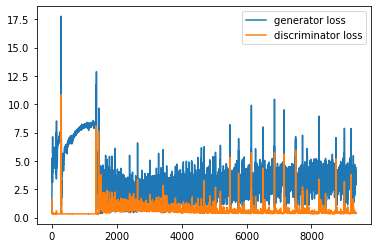

In [8]:
#PLOT GENERATOR AND DISCRIMINATOR LOSSES
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.show()

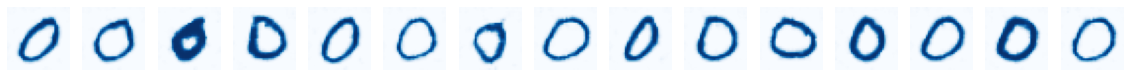

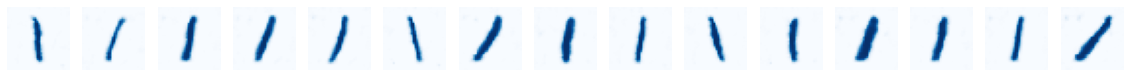

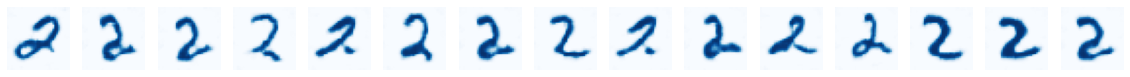

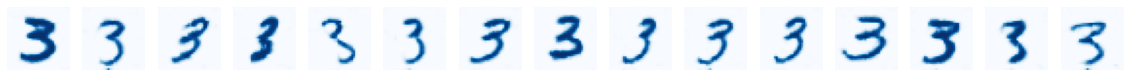

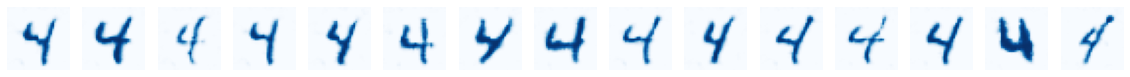

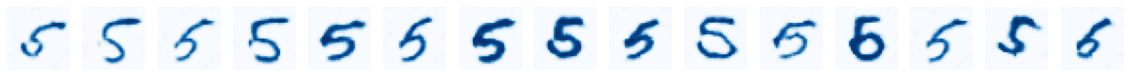

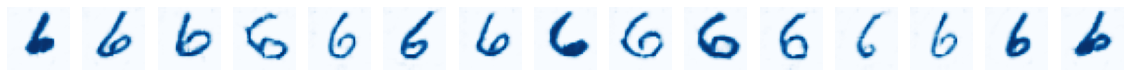

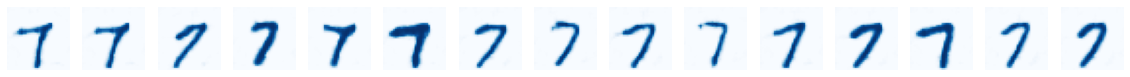

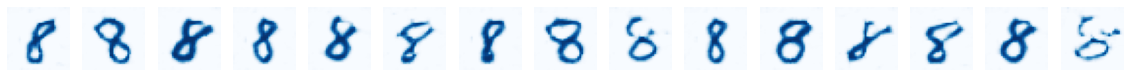

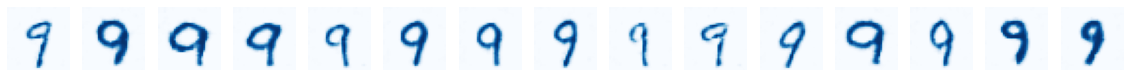

In [9]:
#PLOT GENERATED IMAGES WITHIN CONDINTION FROM 0 TO 9
model.eval()
for k in range(10):
    ## make new tensor images
    z = torch.zeros((targets.size(0), set_latent_dim)).uniform_(-1.0, 1.0).to(device)
    actual_labels, y = random_same_onehot_labels(k, targets.size(0))
    y = y.to(device)
    generated_features = model.generator_forward(z, y)
    imgs = generated_features.view(-1, 32, 32)
    ##plot tensor images
    fig, axes = plt.subplots(nrows=1, ncols=15, figsize=(20, 2.5))
    for i, ax in enumerate(axes):
        axes[i].axis('off')
        axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='Blues')